In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import scipy.interpolate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
from optimise_GDD_fctns import Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array
import seaborn as sns

import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import numpy.ma as ma
from pyproj import Proj, transform
import rioxarray


#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\optimise_GDD_fctns.py:35: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_14840\1111537505.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [5]:
big_errors

,Unnamed: 0,Stations_id,year,fitted,observed,error,lat,lon
0,0,9719.0,2023.0,109.0,128.0,19.0,51.3167,8.7333
1,8,10487.0,2019.0,97.0,117.0,20.0,49.0833,9.8833
2,16,11306.0,2008.0,95.0,112.0,17.0,49.6833,12.1667
3,28,10802.0,2010.0,101.0,123.0,22.0,47.7167,8.4333
4,30,8430.0,2008.0,96.0,78.0,18.0,52.2833,7.2833
...,...,...,...,...,...,...,...,...
133,1780,9522.0,2006.0,95.0,79.0,16.0,50.0500,8.9333
134,1830,11891.0,2020.0,96.0,79.0,17.0,49.7000,10.0833
135,1877,11033.0,2012.0,90.0,120.0,30.0,48.7833,11.2833
136,1899,11622.0,2020.0,99.0,118.0,19.0,49.3000,10.5833


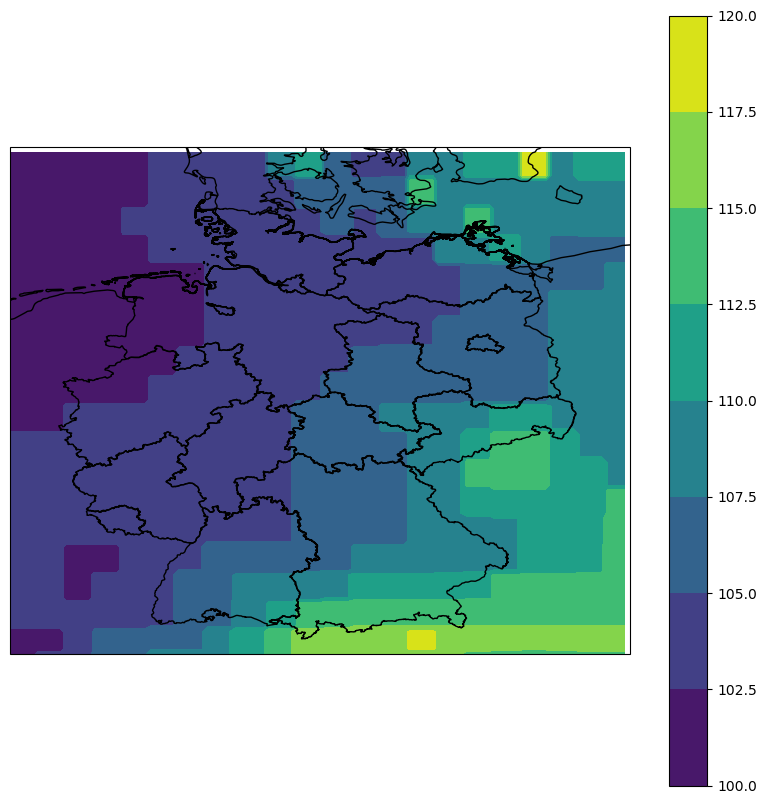

In [25]:
lat = np.arange(47, 56, 0.1)
lon = np.arange(5, 16, 0.1)
LAT, LON = np.meshgrid(lat, lon)
SOS = np.maximum(dataset_fctns.WC_SOS(LON, LAT), 100)

fig, ax = plotting.Germany_plot()
cont = ax.contourf(LON, LAT, SOS, cmap='viridis', vmin  = 100, transform=ccrs.PlateCarree())
plt.colorbar(cont)

In [34]:
hyras_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc').sel(time=slice('2000-01-01', '2020-12-31'))
hyras_data = hyras_data.drop(['x', 'y']).rename({'x': 'lon', 'y': 'lat'})
hyras_data= hyras_data.drop(['time_bnds', 'x_bnds', 'y_bnds'])
hyras_data= hyras_data.drop(['crs_HYRAS', 'number_of_stations'])
#hyras_data = hyras_data.rename({'y': 'lat', 'x': 'lon'})


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24964\1752857012.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data = hyras_data.drop(['x', 'y']).rename({'x': 'lon', 'y': 'lat'})
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24964\1752857012.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data= hyras_data.drop(['time_bnds', 'x_bnds', 'y_bnds'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24964\1752857012.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data= hyras_data.drop(['crs_HYRAS', 'number_of_stations'])


In [6]:
ERA5_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc').sel(time=slice('2000-01-01', '2024-12-31'))
ERA5_data = ERA5_data.rename({'latitude': 'lat', 'longitude': 'lon'})

In [3]:
import os
os.environ['PROJ_DATA'] = "C:\\ProgramData\\anaconda3\\envs\\Data_Analysis_Revived\\Lib\\site-packages\\rasterio\\proj_data"
xds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc', decode_coords="all").sel(time=slice('2000-01-01', '2020-12-31'))
xds = xds.rio.write_crs("EPSG:3035")
xds = xds.drop(['lon', 'lat'])
xds_lonlat = xds.rio.reproject("EPSG:4326")

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24964\1201156179.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  xds = xds.drop(['lon', 'lat'])


In [4]:
hyras_data = xds_lonlat.rename({'x': 'lon', 'y': 'lat'})

In [37]:
ERA5_data

<xarray.Dataset> Size: 827MB
Dimensions:   (lat: 91, lon: 111, time: 5114)
Coordinates:
    number    int64 8B ...
  * lat       (lat) float64 728B 56.0 55.9 55.8 55.7 ... 47.3 47.2 47.1 47.0
  * lon       (lon) float64 888B 5.0 5.1 5.2 5.3 5.4 ... 15.7 15.8 15.9 16.0
  * time      (time) datetime64[ns] 41kB 2011-01-01 2011-01-02 ... 2024-12-31
Data variables:
    d2m       (time, lat, lon) float32 207MB ...
    t2m       (time, lat, lon) float32 207MB nan nan nan ... -0.5993 -0.6115
    ssrd      (time, lat, lon) float32 207MB ...
    tp        (time, lat, lon) float32 207MB ...
    t2m mean  (lat, lon) float32 40kB nan nan nan nan ... 10.73 10.81 10.92
Attributes: (12/32)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      10101
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [5]:
hyras_data['time'] = hyras_data['time']  + np.timedelta64(12, 'h')

In [8]:
hyras_data = hyras_data.sel(lat = list(reversed(hyras_data['lat'])))

In [9]:
hyras_data

<xarray.Dataset> Size: 2GB
Dimensions:             (lon: 299, lat: 179, time: 7671)
Coordinates:
  * lon                 (lon) float64 2kB -1.805 -1.747 -1.689 ... 15.43 15.49
  * lat                 (lat) float64 1kB 41.55 41.61 41.67 ... 51.82 51.88
  * time                (time) datetime64[ns] 61kB 2000-01-02 ... 2021-01-01
    crs_HYRAS           int32 4B 0
Data variables:
    tas                 (time, lat, lon) float32 2GB nan nan nan ... nan nan nan
    number_of_stations  (time) float64 61kB ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [10]:
ERA5_data['tas'] = hyras_data['tas'].interp(lat = ERA5_data['lat'], lon = ERA5_data['lon'])

In [11]:
ERA5_data['diff'] = ERA5_data['tas'] - ERA5_data['t2m']

In [14]:
hyras_data['t2m'] = ERA5_data['t2m'].interp(lat = hyras_data['lat'], lon = hyras_data['lon'])

(45.0, 52.0)

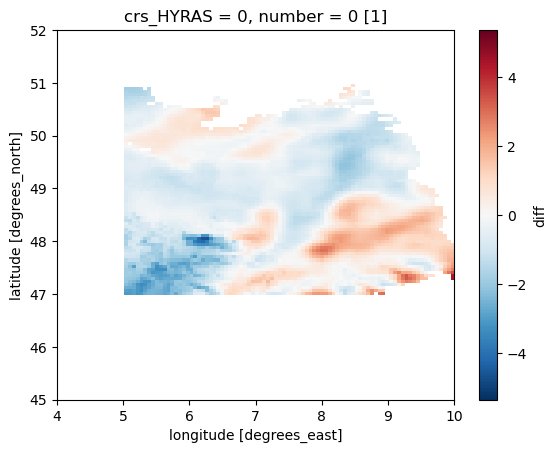

In [15]:
hyras_data['diff'] = hyras_data['tas'] - hyras_data['t2m']
fig, ax = plt.subplots()
hyras_data['diff'].mean(dim='time').plot(ax = ax)
ax.set_xlim((4, 10))
ax.set_ylim((45, 52))

(45.0, 52.0)

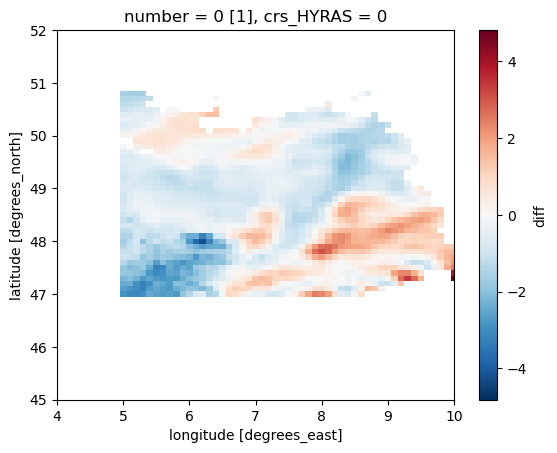

In [13]:
fig, ax = plt.subplots()
ERA5_data['diff'].mean(dim='time').plot(ax = ax)
ax.set_xlim((4, 10))
ax.set_ylim((45, 52))

In [56]:
hyras_averages = hyras_data.mean(dim='time')
ERA5_averages = ERA5_data.mean(dim='time')

In [57]:
hyras_averages['t2m'] = ERA5_averages['t2m'].interp(lat=hyras_averages['lat'], lon=hyras_averages['lon'])

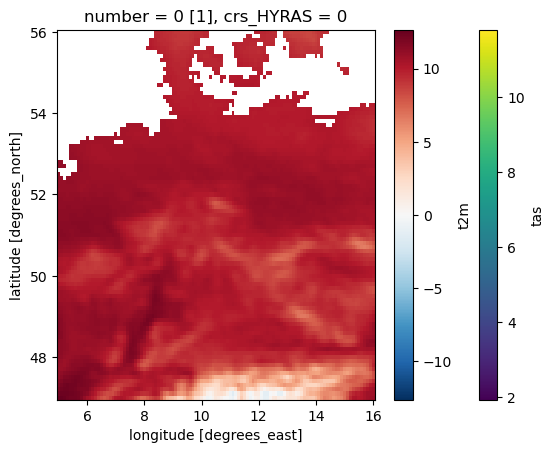

In [63]:
fig, ax = plt.subplots()
hyras_averages['tas'].plot(ax = ax)
ERA5_averages['t2m'].plot(ax = ax)

In [64]:
(ERA5_averages['t2m'] - hyras_averages['tas']).plot()

TypeError: No numeric data to plot.

In [28]:
#%conda activate
# Data_Analysis_Revived
#pyproj.datadir.set_data_dir("C:\\ProgramData\\anaconda3\\envs\\Data_Analysis_Revived\\Lib\\site-packages\\rasterio\\proj_data")


In [20]:
import pyproj
pyproj.datadir.get_data_dir()#"C:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\rasterio\proj_data\proj.db")

'C:\\ProgramData\\anaconda3\\envs\\Data_Analysis_Revived\\Library\\share\\proj'

In [ ]:
"C:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\rasterio\proj_data\proj.db"

In [ ]:
"C:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Library\share\proj\proj.db"

In [15]:
hyras_data.crs_HYRAS

<xarray.DataArray 'crs_HYRAS' ()> Size: 4B
array(1)
Attributes: (12/16)
    grid_mapping_name:                  lambert_conformal_conic
    long_name:                          DWD HYRAS ETRS89 LCC grid with 240 co...
    standard_parallel:                  [35. 65.]
    longitude_of_central_meridian:      10.0
    latitude_of_projection_origin:      52.0
    semi_major_axis:                    6378137.0
    ...                                 ...
    scale_factor_at_projection_origin:  0.017453292519943295
    proj4:                              +proj=lcc +lat_1=35 +lat_2=65 +lat_0=...
    proj4_params:                       +proj=lcc +lat_1=35 +lat_2=65 +lat_0=...
    epsg_code:                          EPSG:3034
    crs_wkt:                            PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ET...
    spatial_ref:                        PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ET...

In [18]:
hd = hyras_data['tas'].coarsen(lon=4).std().coarsen(lat=4).std()

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [22]:
hd.isel(lon=25, lat = 25)

<xarray.DataArray 'tas' (time: 7671)> Size: 31kB
array([0.05299022, 0.06848152, 0.07651997, ..., 0.05393928, 0.06201186,
       0.06041406], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 61kB 2000-01-01T12:00:00 ... 2020-12-31T12...
    lon      float64 8B 10.15
    lat      float64 8B 50.23
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Mean Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: mean
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...

In [53]:
ERA5_data_t2m = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2020.nc')
ERA5_data_skin = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Germany Skin\\ERA5_skin_DE_2020.nc')

In [55]:
ds_skin

<xarray.Dataset> Size: 118MB
Dimensions:  (time: 2928, lat: 91, lon: 111)
Coordinates:
    number   int64 8B ...
  * time     (time) datetime64[ns] 23kB 2020-01-01 ... 2020-12-31T21:00:00
  * lat      (lat) float64 728B 56.0 55.9 55.8 55.7 55.6 ... 47.3 47.2 47.1 47.0
  * lon      (lon) float64 888B 5.0 5.1 5.2 5.3 5.4 ... 15.6 15.7 15.8 15.9 16.0
    expver   (time) <U4 47kB ...
Data variables:
    skt      (time, lat, lon) float32 118MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-04T09:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
ds_t2m = ERA5_data_t2m.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
ds_skin = ERA5_data_skin.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
#ds = ds.sortby('time')
t2m = ds_t2m['t2m'].resample(time="1D").mean()


In [57]:
t2m['skt'] = skin

In [61]:
t2m.values

array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [272.2754 , 272.18335, 272.12793, ..., 273.30884, 273.3711 ,
         273.3994 ],
        [272.18164, 272.10864, 272.08667, ..., 273.31348, 273.29785,
         273.28687],
        [272.18506, 272.1206 , 272.15576, ..., 273.54175, 273.51343,
         273.5332 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [274.286  , 274.28967, 274.2157 , ..., 273.14563, 273.12927,
         273.38855],
        [274.28748, 274.28455, 274.2345 , ..., 272.89343, 272.95227,
   

In [62]:
t2m['diff'] = t2m.values - t2m['skt']

In [72]:
t2m['diff'].std(dim=['time', 'lat', 'lon'])#.plot(vmax = 1, vmin = 0)#vmin = -1, vmax = 1, cmap = 'coolwarm')

<xarray.DataArray 'diff' ()> Size: 4B
array(0.8114812, dtype=float32)
Coordinates:
    number   int64 8B ...

In [56]:
skin = ds_skin['skt'].resample(time="1D").mean()

In [79]:
ERA5_data_t2m = ERA5_data_t2m.rename({'valid_time': 'time'})

In [80]:
tmax = ERA5_data_t2m['t2m'].resample(time="1D").max()
tmin = ERA5_data_t2m['t2m'].resample(time="1D").min()

In [84]:
diffmean = (tmax - tmin).std(dim = ['time', 'latitude', 'longitude'])

In [85]:
diffmean

<xarray.DataArray 't2m' ()> Size: 4B
array(3.4703372, dtype=float32)
Coordinates:
    number   int64 8B 0

In [35]:
np.any(tmax > 273.5 + 35)

<xarray.DataArray 't2m' ()> Size: 1B
array(False)
Coordinates:
    number   int64 8B ...

In [18]:
hyras_lon = hyras_data.lon.values
hyras_lat = hyras_data.lat.values
ERA5_lon = ERA5_data.lon.values
ERA5_lat = ERA5_data.lat.values
#hyras_LON, hyras_LAT = np.meshgrid(hyras_lon, hyras_lat)
ERA5_LON, ERA5_LAT = np.meshgrid(ERA5_lon, ERA5_lat)


In [37]:
ERA5_data['t2m'].max()

<xarray.DataArray 't2m' ()> Size: 8B
array(32.26480103)
Coordinates:
    number   int64 8B ...

In [45]:
ERA5_data['t2m mean'] = ERA5_data.t2m.mean(dim='time')
hyras_data['ERA5 t2m'] = (('time', 'lat', 'lon'), np.zeros(hyras_data.tas.values.shape))
interpolated_temps = []
for year in range(2011, 2020):
    if year % 4 == 0:
        numdays = 366
    else:
        numdays = 365
    for day in range(numdays):#366
        date = np.datetime64(f'{year}-01-01') + np.timedelta64(day, 'D')
        print(date)
        ERA5_interpolator = scipy.interpolate.RegularGridInterpolator((ERA5_lat, ERA5_lon), ERA5_data.t2m.sel(time=date).values, method='linear', bounds_error=False, fill_value=None)
        interpolated_temps.append(ERA5_interpolator((hyras_lat, hyras_lon)))

hyras_data['ERA5 t2m'] = (('time', 'lat', 'lon'), np.array(interpolated_temps))#ERA5_interpolator((hyras_lat, hyras_lon))#hyras_data.assign({'ERA5 t2m':(('lat', 'lon'), ERA5_interpolator((hyras_lat, hyras_lon)))})

2011-01-01
2011-01-02
2011-01-03
2011-01-04
2011-01-05
2011-01-06
2011-01-07
2011-01-08
2011-01-09
2011-01-10
2011-01-11
2011-01-12
2011-01-13
2011-01-14
2011-01-15
2011-01-16
2011-01-17
2011-01-18
2011-01-19
2011-01-20
2011-01-21
2011-01-22
2011-01-23
2011-01-24
2011-01-25
2011-01-26
2011-01-27
2011-01-28
2011-01-29
2011-01-30
2011-01-31
2011-02-01
2011-02-02
2011-02-03
2011-02-04
2011-02-05
2011-02-06
2011-02-07
2011-02-08
2011-02-09
2011-02-10
2011-02-11
2011-02-12
2011-02-13
2011-02-14
2011-02-15
2011-02-16
2011-02-17
2011-02-18
2011-02-19
2011-02-20
2011-02-21
2011-02-22
2011-02-23
2011-02-24
2011-02-25
2011-02-26
2011-02-27
2011-02-28
2011-03-01
2011-03-02
2011-03-03
2011-03-04
2011-03-05
2011-03-06
2011-03-07
2011-03-08
2011-03-09
2011-03-10
2011-03-11
2011-03-12
2011-03-13
2011-03-14
2011-03-15
2011-03-16
2011-03-17
2011-03-18
2011-03-19
2011-03-20
2011-03-21
2011-03-22
2011-03-23
2011-03-24
2011-03-25
2011-03-26
2011-03-27
2011-03-28
2011-03-29
2011-03-30
2011-03-31
2011-04-01

In [42]:
np.array(interpolated_temps).shape

(3287, 220, 240)

In [39]:
hyras_data.tas.values.shape

(3288, 220, 240)

In [41]:
hyras_data['ERA5 t2m'].shape# = (('time', 'lat', 'lon'), np.array(interpolated_temps))

(3288, 220, 240)

In [44]:
hyras_data = hyras_data.sel(time=slice('2011-01-01', '2019-12-31'))

In [ ]:
hyras

In [46]:
hyras_data['diff'] = hyras_data.tas - hyras_data['ERA5 t2m']
#ERA5_clim = ERA5_data.mean(dim='time')
#ERA5_ge_10 = ERA5_clim.where(ERA5_clim.t2m > 10, drop = True)

In [73]:
hyras_data

<xarray.Dataset> Size: 3GB
Dimensions:   (time: 3287, lat: 220, lon: 240)
Coordinates:
  * time      (time) datetime64[ns] 26kB 2011-01-01T12:00:00 ... 2019-12-31T1...
    lon       (lat, lon) float64 422kB 3.451 3.517 3.582 ... 21.19 21.27 21.35
    lat       (lat, lon) float64 422kB 45.31 45.31 45.32 ... 55.21 55.2 55.19
Data variables:
    tas       (time, lat, lon) float32 694MB nan nan nan nan ... nan nan nan nan
    ERA5 t2m  (time, lat, lon) float64 1GB 14.09 13.63 13.18 ... nan nan nan
    diff      (time, lat, lon) float64 1GB nan nan nan nan ... nan nan nan nan
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [75]:
hyras_data['diff'].std(dim=['time', 'lat', 'lon'])

<xarray.DataArray 'diff' ()> Size: 8B
array(0.85978798)

In [47]:
meandiff = hyras_data['diff'].sel(time=slice('2000-01-01', '2020-12-31')).mean(dim='time')#.plot

In [48]:
meandiff

<xarray.DataArray 'diff' (lat: 220, lon: 240)> Size: 422kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (lat, lon) float64 422kB 3.451 3.517 3.582 ... 21.19 21.27 21.35
    lat      (lat, lon) float64 422kB 45.31 45.31 45.32 ... 55.21 55.2 55.19

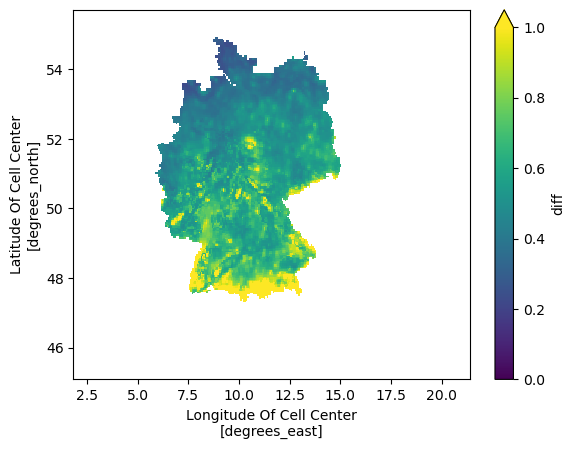

In [68]:
fig, ax = plt.subplots()
hyras_data['diff'].sel(time=slice('2000-01-01', '2020-12-31')).var(dim='time').plot(ax=ax, vmax = 1, vmin = 0)

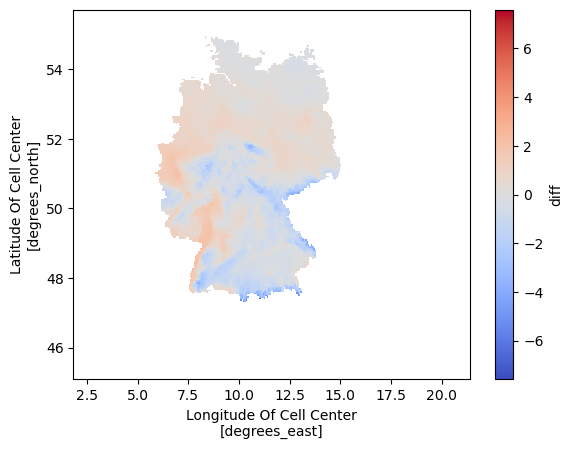

In [46]:
(meandiff - meandiff.mean()).plot(cmap = 'coolwarm')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_14840\781927006.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


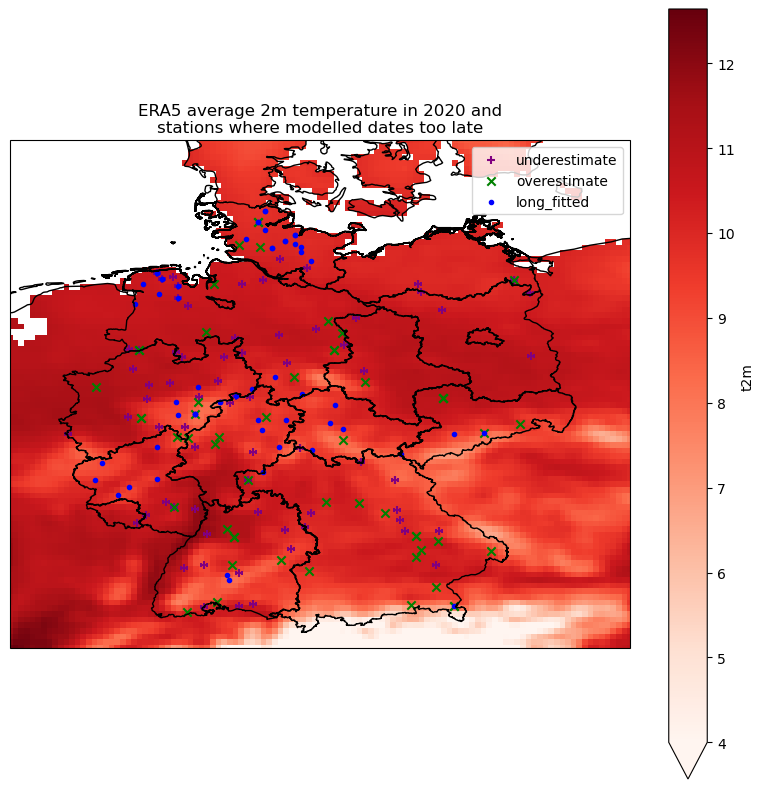

In [15]:
fig, ax = plotting.Germany_plot()
#stat_locs = pd.read_csv('Saved_files/canm_latlon3.csv')
bf_locs = pd.read_csv('Saved_files/cabf_latlon.csv')#3
lm_locs = pd.read_csv('Saved_files/calm_latlon.csv')#3
#for year_index, year in enumerate(stat_locs['Referenzjahr'].unique()):
#    stat_locs_year = stat_locs.where(stat_locs['Referenzjahr'] == year).dropna()
#    ax.scatter(stat_locs_year['lon'], stat_locs_year['lat'], label=year, color = ['r', 'g', 'b', 'k', 'purple', 'orange', 'yellow'][year_index])#, 'ro', transform=ccrs.PlateCarree())
#stat_locs = stat_locs.where(stat_locs['Referenzjahr'] == 2004).dropna()
#, 'ro', transform=ccrs.PlateCarree())
#hyras_data['tas'].mean(dim='time').plot(cmap = 'Reds', ax=ax)#std(dim='time').plot(vmax=1)#.plot(vmin = -1, vmax = 1, cmap = 'coolwarm')#.isel(time=150)vmin = 0, vmax = 20, 
temp_map = ERA5_data['t2m'].mean(dim='time').plot(cmap = 'Reds', ax=ax, vmin = 4)
#temp_map = ERA5_ge_10['t2m'].plot(cmap = 'Reds', ax=ax, vmin = 4)
ax.set_title('ERA5 average 2m temperature in 2020 and\nstations where modelled dates too late')
#plt.colorbar(temp_map, label='Temperature (°C)')
#hyras_data['diff'].mean(dim='time').plot(cmap = 'coolwarm', ax=ax, vmin = -1, vmax = 1)
#ax.scatter(stat_locs['lon'], stat_locs['lat'], color = 'green', marker='x', label='Didn\'t mature')
#ax.scatter(lm_locs['lon'], lm_locs['lat'], color = 'purple', marker='+', label='Modelled maturity\ntoo late')
#ax.scatter(bf_locs['lon'], bf_locs['lat'], color = 'blue', marker='.', label='Modelled flowering\ntoo late')
station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
overestimate = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\overestimate.csv')
overestimate = get_station_locations(overestimate, station_data)
underestimate = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\underestimate.csv')
underestimate = get_station_locations(underestimate, station_data)
long_fitted = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\long_fitted.csv')
long_fitted = get_station_locations(long_fitted, station_data)
ax.scatter(underestimate['lon'], underestimate['lat'], color = 'purple', marker='+', label='underestimate')
ax.scatter(overestimate['lon'], overestimate['lat'], color = 'green', marker='x', label='overestimate')
ax.scatter(long_fitted['lon'], long_fitted['lat'], color = 'blue', marker='.', label='long_fitted')
ax.legend()

In [65]:
hyras_interpolator = scipy.interpolate.RegularGridInterpolator((hyras_lat, hyras_lon), hyras_data.tas.values, method='linear', bounds_error=False, fill_value=None)

ValueError: The points in dimension 1 must be strictly ascending or descending

In [45]:
ERA5_data.lat.sortby('lat')

<xarray.DataArray 'lat' (lat: 91)> Size: 728B
array([47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6, 47.7, 47.8, 47.9, 48. , 48.1,
       48.2, 48.3, 48.4, 48.5, 48.6, 48.7, 48.8, 48.9, 49. , 49.1, 49.2, 49.3,
       49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50. , 50.1, 50.2, 50.3, 50.4, 50.5,
       50.6, 50.7, 50.8, 50.9, 51. , 51.1, 51.2, 51.3, 51.4, 51.5, 51.6, 51.7,
       51.8, 51.9, 52. , 52.1, 52.2, 52.3, 52.4, 52.5, 52.6, 52.7, 52.8, 52.9,
       53. , 53.1, 53.2, 53.3, 53.4, 53.5, 53.6, 53.7, 53.8, 53.9, 54. , 54.1,
       54.2, 54.3, 54.4, 54.5, 54.6, 54.7, 54.8, 54.9, 55. , 55.1, 55.2, 55.3,
       55.4, 55.5, 55.6, 55.7, 55.8, 55.9, 56. ])
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 728B 47.0 47.1 47.2 47.3 47.4 ... 55.7 55.8 55.9 56.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [61]:
hyras_data.reindex({'lat':ERA5_data.lat, 'lon':ERA5_data.lon}, method='nearest')

ValueError: cannot reindex or align along dimension 'lat' because of conflicting dimension sizes: {91, 220} (note: an index is found along that dimension with size=91)

In [60]:
hyras_data.interp_like(ERA5_data)#({'lat':ERA5_data.lat.sortby('lat').values, 'lon':ERA5_data.lon.sortby('lon').values},method='nearest')# 'time':np.datetime64('2020-05-19')}, method='nearest')

ValueError: Input DataArray is not 1-D.

In [27]:
hyras_data.reindex(lat=ERA5_data['lat'], lon=ERA5_data['lon'], method='nearest')

<xarray.Dataset> Size: 78MB
Dimensions:             (time: 366, bnds: 2, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 3kB 2020-01-01T12:00:00 ... 202...
    lon                 (y, x) float64 422kB ...
    lat                 (y, x) float64 422kB ...
  * x                   (x) float32 960B 3.502e+06 3.508e+06 ... 4.698e+06
  * y                   (y) float32 880B 2.102e+06 2.108e+06 ... 3.198e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 6kB ...
    x_bnds              (x, bnds) float32 2kB ...
    y_bnds              (y, bnds) float32 2kB ...
    crs_HYRAS           int32 4B ...
    tas                 (time, y, x) float32 77MB ...
    number_of_stations  (time) float64 3kB ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

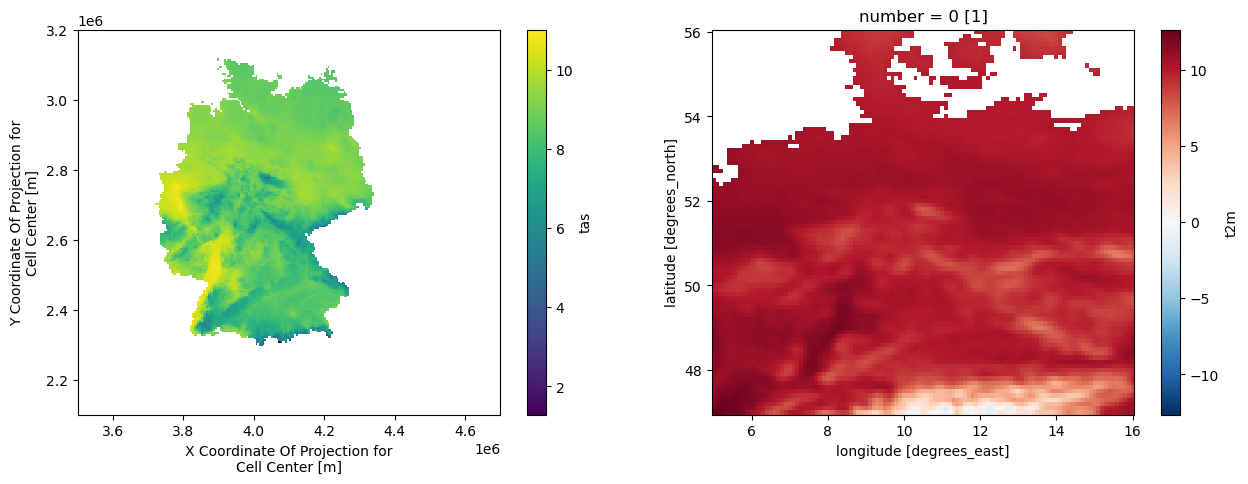

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
hyras_data['tas'].mean(dim='time').plot(ax=axs[0])
ERA5_data['t2m'].mean(dim='time').plot(ax=axs[1])

In [11]:
stat_locs['Referenzjahr'].unique()

array([2004., 2010., 2012., 2015., 2011., 2014., 2007., 2002., 2008.,
       2020., 2016.])

IndexError: list index out of range

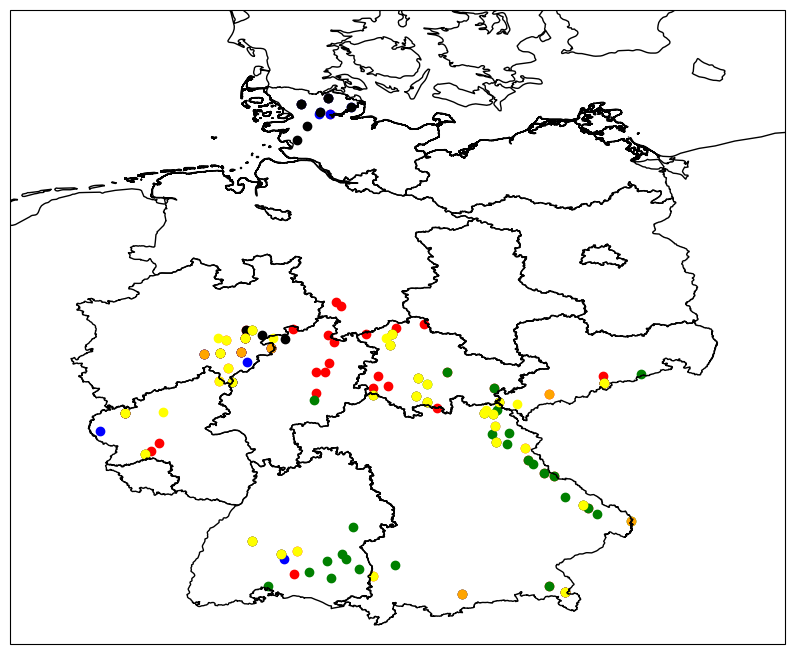

In [15]:
fig, ax = plotting.Germany_plot()
stat_locs = pd.read_csv('Saved_files/canm_latlon.csv')
for year_index, year in enumerate(stat_locs['Referenzjahr'].unique()):
    stat_locs_year = stat_locs.where(stat_locs['Referenzjahr'] == year).dropna()
    ax.scatter(stat_locs_year['lon'], stat_locs_year['lat'], label=year, color = ['r', 'g', 'b', 'k', 'purple', 'orange', 'yellow'][year_index])#, 'ro', transform=ccrs.PlateCarree())
stat_locs = stat_locs.where(stat_locs['Referenzjahr'] == 2004).dropna()
ax.scatter(stat_locs['lon'], stat_locs['lat'])#, 'ro', transform=ccrs.PlateCarree())

In [2]:
for y in range(2010, 2011):
    print(y)

2010


In [2]:
#ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2020.nc')
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_2015.nc')
for year in range(2016, 2017):
    print(year)
    ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_{year}.nc')], dim='valid_time')
ds = ds.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
ds = ds.sortby('time')

2016


In [3]:
ds

<xarray.Dataset> Size: 15GB
Dimensions:  (time: 29224, lat: 431, lon: 291)
Coordinates:
    number   int64 8B 0
  * time     (time) datetime64[ns] 234kB 1999-01-01 ... 2008-12-31T21:00:00
  * lat      (lat) float64 3kB 12.5 12.4 12.3 12.2 ... -30.2 -30.3 -30.4 -30.5
  * lon      (lon) float64 2kB 11.5 11.6 11.7 11.8 11.9 ... 40.2 40.3 40.4 40.5
    expver   (time) <U4 468kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Data variables:
    t2m      (time, lat, lon) float32 15GB 293.3 293.3 293.2 ... nan nan nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-18T16:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
#d2m = ds['d2m'].resample(time="1D").mean()
t2m = ds['t2m'].resample(time="1D").mean()
t2max = ds['t2m'].resample(time="1D").max()
t2max = t2max.rename('t2max')
t2min = ds['t2m'].resample(time="1D").min()
t2min = t2min.rename('t2min')
ds_for_driver = xr.merge([t2m, t2max, t2min])
ds_for_driver['t2m'] += -273.15
ds_for_driver['t2max'] += -273.15
ds_for_driver['t2min'] += -273.15
ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_2015_2017.nc')

In [5]:
#t2max['t2max'] = t2max
#t2max = t2max.drop('t2m')


In [6]:

#t2min['t2min'] = t2min['t2m']
#t2min = t2min.drop('t2m')


In [9]:
ds_for_driver['Averaging_Discrepancy'] = (ds_for_driver['t2max'] + ds_for_driver['t2min'])/2 - ds_for_driver['t2m']

In [11]:
diffs = ds_for_driver['Averaging_Discrepancy'].mean(dim='time')

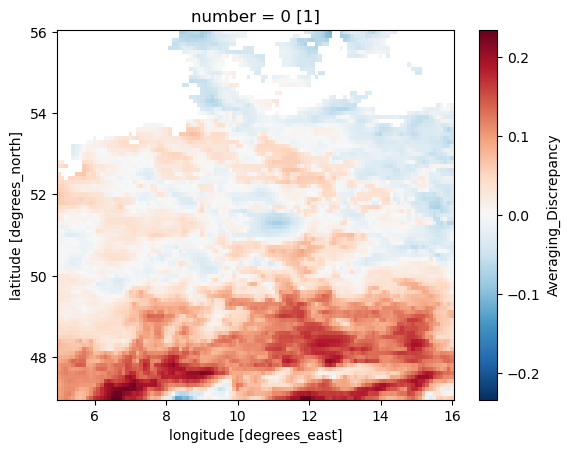

In [12]:
diffs.plot()

In [7]:
ds_for_solrad = ds.where((ds['time.hour'] > 5)*(ds['time.hour'] < 19), drop=True)
ssrd = ds_for_solrad['ssrd'].resample(time="1D").mean()

: 

In [ ]:
tp = ds['tp'].resample(time="1D").sum()

In [ ]:
ds_for_driver = xr.merge([d2m, t2m, ssrd, tp, t2max, t2min])
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds_for_driver = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
ds_for_driver['t2m'] += -273.15
ds_for_driver['t2max'] += -273.15
ds_for_driver['t2min'] += -273.15
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
#ds.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds3 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')

In [9]:
#ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
#ds.close()
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2001_2010.nc')

#ds_to_save = xr.concat([ds_for_driver, ds], dim='time')
#ds_to_save

In [3]:
ds1

<xarray.Dataset> Size: 827MB
Dimensions:    (latitude: 91, longitude: 111, time: 5114)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 728B 56.0 55.9 55.8 55.7 ... 47.2 47.1 47.0
  * longitude  (longitude) float64 888B 5.0 5.1 5.2 5.3 ... 15.7 15.8 15.9 16.0
  * time       (time) datetime64[ns] 41kB 2011-01-01 2011-01-02 ... 2024-12-31
Data variables:
    d2m        (time, latitude, longitude) float32 207MB ...
    t2m        (time, latitude, longitude) float32 207MB ...
    ssrd       (time, latitude, longitude) float32 207MB ...
    tp         (time, latitude, longitude) float32 207MB ...
Attributes: (12/32)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      10101
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [13]:
ds1 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
ds2 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2001_2010.nc')
ds2.close()
ds2 = ds2.where(ds2['time'] < np.datetime64('2011-01-01'), drop = True)
ds2.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
#ds_to_save = xr.concat([ds1, ds2], dim='time')

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'rasterio']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [8]:
np.datetime64('2011-01-01')

numpy.datetime64('2011-01-01')

In [5]:
print(ds1['time'].min().values,
      ds2['time'].max().values)

2011-01-01T00:00:00.000000000 2011-12-31T00:00:00.000000000


In [22]:
ds1

<xarray.Dataset> Size: 827MB
Dimensions:    (latitude: 91, longitude: 111, time: 5114)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 728B 56.0 55.9 55.8 55.7 ... 47.2 47.1 47.0
  * longitude  (longitude) float64 888B 5.0 5.1 5.2 5.3 ... 15.7 15.8 15.9 16.0
  * time       (time) datetime64[ns] 41kB 2011-01-01 2011-01-02 ... 2024-12-31
Data variables:
    d2m        (time, latitude, longitude) float32 207MB ...
    t2m        (time, latitude, longitude) float32 207MB ...
    ssrd       (time, latitude, longitude) float32 207MB ...
    tp         (time, latitude, longitude) float32 207MB ...
Attributes: (12/32)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      10101
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0